In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model
import os
import random
import matplotlib.transforms as mtransforms

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,header.index("Dates")]
    infected = infectionData[:,header.index("Infected")]
    recovered = infectionData[:,header.index("Recovered")]
    deaths = infectionData[:,header.index("Deaths")]
    #vacc = infectionData[:,header.index("Vaccinated")]
    #vacc = vacc.astype(float)
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    return dates, infected, recovered, deaths#, vacc

def getGamma(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def getPopC(county,state):
    path="../Data/"
    csvfile=open(path+"PopulationEstimates.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][1] and county in aData[i][2]:
            temp = aData[i][19]
            pop = float(temp.replace(',',''))
    return pop
def getNu(infect, dead):
    
    recovG = approxRecovered(infect,dead)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def approxRecovered(infect,dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead,winSize):
    

    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect,dead)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2

    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
    for i in range(len(Beta)):
        if np.isnan(Beta[i]):
            Beta[i] = 0
        if np.isinf(Beta[i]):
            Beta[i] = 0
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, (pointArray), rcond=None)
    slope = point_slope[1]
    return res, slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        res, slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getOandC(filename, smallerCategories = False):

    if(smallerCategories):
        bO = []
        sO = []
        bC = []
        sC = []
        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
       
        for i in range(len(aData)):
            if("Major Closure" in aData[i][1]):
                bC.append(aData[i][0])
            if("Minor Closure" in aData[i][1]):
                sC.append(aData[i][0])
            if("Minor Opening" in aData[i][1]):
                sO.append(aData[i][0])
            if("Major Opening" in aData[i][1]):
                bO.append(aData[i][0])

        return bO,sO,bC,sC
    else:
        O = []
        C = []

        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
        for i in range(len(aData)):
            if("Closure" in aData[i][1]):
                C.append(aData[i][0])
            if("Opening" in aData[i][1]):
                O.append(aData[i][0])
        return O,C



def displayOandC(filename, beta, ax, dates,window, smallerCategories = False):
    #Add or modify dates for closures or openings here

    if(smallerCategories):
        bOpening,sOpening, bClosure, sClosure = getOandC(filename, smallerCategories)

        bOind = []
        sOind = []
        bCind = []
        sCind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(bOpening)):
            bOind.append(temp.index(bOpening[i]))
        for i in range(len(sOpening)):
            sOind.append(temp.index(sOpening[i]))
        for i in range(len(bClosure)):
            bCind.append(temp.index(bClosure[i]))
        for i in range(len(sClosure)):
            sCind.append(temp.index(sClosure[i]))

        #Variables used to fix legend duplications
        temp1 = 0
        temp3 = 0
        temp2 = 0
        temp4 = 0
        #Add the dashed lines going up to the beta curve

        for i in range(len(bOind)): 
            if(temp1 == 0):
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]], label = "Major Openings")
                temp1 = 1
            else:
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]] )
        for i in range(len(sOind)): 
            if(temp3 == 0):
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]], label = "Minor Openings")
                temp3 = 1
            else:
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]] )
        for i in range(len(bCind)):
            if(temp2 == 0):
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]], label = "Major Closures")
                temp2 = 1
            else:
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]])
        for i in range(len(sCind)):
            if(temp4 == 0):
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]], label = "Minor Closures")
                temp4 = 1
            else:
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]])
        ax.legend(fontsize=20)
    else:
        Opening, Closure = getOandC(filename, smallerCategories)

        Oind = []
        Cind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(Opening)):
            Oind.append(temp.index(Opening[i]))
        for i in range(len(Closure)):
            Cind.append(temp.index(Closure[i]))


        #Variables used to fix legend duplications
        temp1 = 0
        temp2 = 0

        #Add the dashed lines going up to the beta curve
        for i in range(len(Oind)): 
            if(temp1 == 0):
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]], label = "Openings")
                temp1 = 1
            else:
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]] )
        for i in range(len(Cind)):
            if(temp2 == 0):
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]], label = "Closures")
                temp2 = 1
            else:
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]])
        ax.legend(fontsize=20)
    
#predict the next some days using constant parameters
def calculateFuture(infect, recov, dead, pop, daysToPredict, params, q):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T-1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params


#predict future days that are not known
def predictFuture(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect, recov, dead, pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))

    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')
        
def getBetaDiffC(dates,simDate,beta,infect,dead,pop,q,numDays,lag = 8):

    temp = dates.tolist()
    recov = approxRecovered(infect,dead)
    
    sI = simDate[0:len(simDate)-4]
    sA = simDate[len(simDate) - 2: len(simDate)]
    simDate = sI + sA
    simLastEl = temp.index(simDate) + 14+lag >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+14+lag]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+lag:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
  
    recov = approxRecovered(infect,dead)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter

def getBetaDiff(dates,simDate,beta,infect,dead,pop,q,numDays):

    temp = dates.tolist()
    recov = approxRecovered(infect,dead)

    simLastEl = temp.index(simDate) + 21 >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+21]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+7:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
    
    
    recov = approxRecovered(infect,dead)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter
    
def betaWithKernel(beta, winSize=15): #Apply a convolution kernel to the data
    x = np.arange(-winSize // 2, 1 + (winSize // 2))
    kernel2 = np.exp(-(x) ** 2 / (2 * 5 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newBeta = np.convolve(beta, kernel2, 'same')
    return newBeta




convert = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AS':'American Samoa' ,
    'AZ':'Arizona' ,
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'GU':'Guam',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'MP':'Northern Mariana Island',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'PR':'Puerto Rico',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'VI':'Virgin Islands',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
    
}

convert.update(dict(reversed(item) for item in convert.items()))
def getBetaDistribution(mandate, county = False, exact = False, closure=True, regional = False):
    if county:
        arr = os.listdir('../Data/State Closure Data/County Closure Data/')

        bB = [] #Store the Beta Before Values
        bA = [] #Store the Beta After Values

        for file in arr:
            pathc='../Data/JHU Data/County Data/'
            # modify the path syntax based on the current platform
            if platform.system() == "Windows":
                pathc.replace("/", "\\")
            if '.DS_Store' in file:
                continue
            #Change state abbreviation based on the state you want to use

            dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)


            cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
            cName = convert[cState]
            cCounty = file[0:file.index(',')] #Get the county name

            #Change population based on the county you want to use
            pop = int(getPopC(cCounty,cState))
            numDays = len(infectRaw)
            infect = infectRaw[0:numDays]
            dead = deadRaw[0:numDays]

            gamma = getGamma(infect,dead)
            nu = getNu(infect,dead)
            q = 1 #0.0754
            window = 13
            hWin = window // 2
            beta = getBeta(pop, q, infect, dead, window)
            #beta = betaWithKernel(beta)
            #fig, ax = plt.subplots(figsize= (18,8))
            #ax.plot(beta)
            temp = dates.tolist()
            pathc='../Data/State Closure Data/County Closure Data/'

            #Change function call of mM to change the policy
            mM = getMandate(pathc+file, dates, mandate, closure,exact)
            #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
            for k in range(len(mM)): 
                tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
                bB.append(tB)
                bA.append(tA)

        #Get rid of weird invalid cases
        i = 0
        while i < len(bB):
            if bB[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bB[i]):
                del bB[i]
                del bA[i]
                i-= 1
            if np.isinf(bB[i]):
                del bB[i]
                del bA[i]
                i-=1
            i+=1

        i = 0
        while i < len(bA):
            if bA[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bA[i]):
                del bB[i]
                del bA[i]
                i-=1
            if np.isinf(bA[i]):
                del bB[i]
                del bA[i]  
                i-=1
            i+=1
        
    else:
        arr = os.listdir('../Data/Derived State Data/')

        bB = [] #Store the Beta Before Values
        bA = [] #Store the Beta After Values

        for file in arr:
            pathc='../Data/Covid Tracking State Data/'
            # modify the path syntax based on the current platform
            if platform.system() == "Windows":
                pathc.replace("/", "\\")
            if '.DS_Store' in file or 'ipynb' in file:
                continue
            #Change state abbreviation based on the state you want to use
            stateName = file[0:len(file)-4] #Get the county name
            abr = convert[stateName]
            datafile = abr+".csv"

            dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + datafile)

            #Change population based on the state you want to use
            pop = int(getPop(stateName))
            numDays = len(infectRaw)
            infect = infectRaw[0:numDays]
            dead = deadRaw[0:numDays]

            gamma = getGamma(infect,dead)
            nu = getNu(infect,dead)
            q = 1 #0.0754
            window = 13
            hWin = window // 2
            beta = getBeta(pop, q, infect, dead, window)
            #beta = betaWithKernel(beta)
            #fig, ax = plt.subplots(figsize= (18,8))
            #ax.plot(beta)
            temp = dates.tolist()
            pathc='../Data/Derived State Data/'

            #Change function call of mM to change the policy
            mM = getMandate(pathc+file, dates, mandate, closure,exact)

            #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy

            for k in range(len(mM)):
                if 'N/A' in mM[k]:
                    continue
                tB, tA = getBetaDiff(dates,mM[k], beta, infect, dead, pop, q, numDays) 
                bB.append(tB)
                bA.append(tA)

        #Get rid of weird invalid cases
        i = 0
        while i < len(bB):
            if bB[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bB[i]):
                del bB[i]
                del bA[i]
                i-= 1
            if np.isinf(bB[i]):
                del bB[i]
                del bA[i]
                i-=1
            i+=1

        i = 0
        while i < len(bA):
            if bA[i] == 0:
                del bB[i]
                del bA[i]
                i-= 1
            if np.isnan(bA[i]):
                del bB[i]
                del bA[i]
                i-=1
            if np.isinf(bA[i]):
                del bB[i]
                del bA[i]  
                i-=1
            i+=1
        #Plotting the beta before and after points

        
    return bB,bA

    
def getMandate(filename,dates,mandate,closure=True,exact=False, regional = False):
    if closure:
        nixwords = ['Lifted', 'Open']
    else:
        nixwords = ['Closed', 'Restricted']
    if not regional: 
        nixwords.append('Regional')
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    M = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if exact:
            if mandate == aData[i][1]:
                M.append(aData[i][0])
        else:
            if(mandate in aData[i][1]):
                # check if any words which do not belong are in the name
                should_append = True
                for word in nixwords:
                    if (word in aData[i][1]):
                        should_append = False
                if should_append:
                    M.append(aData[i][0])
    return M
    

## Plotting init measures and increasing/decreasing times of infection

Alameda
Los Angeles
Sacramento


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-ha

Contra Costa
Santa Barbara
San Mateo


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-hal

Kern
Fresno
Monterey


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-hal

Orange
Riverside
San Joaquin


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-ha

San Bernardino
San Diego
San Francisco


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-hal

Sonoma
Santa Clara
Solano


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-ha

Stanislaus
Tulare
Ventura


<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) #* Zt[halfwin:len(It)-halfwin]
<ipython-input-2-574c447096c6>:102: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-hal

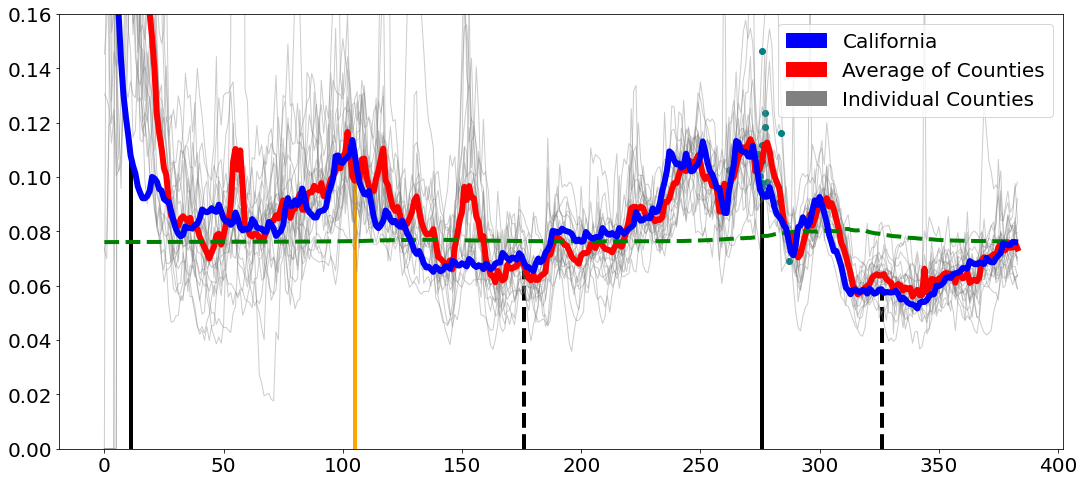

In [29]:
def regionBeta(filename, pop, startDate, endDate):
    dates, infectRaw, recovRaw, deadRaw = loadData(filename)
    
    q = .3
    window = 13

    suscept = q * pop - infectRaw

    beta = getBeta(pop, q, infectRaw, deadRaw, window)
    #beta = betaWithKernel(beta, winSize=15)
    
    startIndex = 0
    while(dates[startIndex] != startDate):
        startIndex += 1
        
    endIndex = 0
    while(dates[endIndex] != endDate):
        endIndex += 1
        
    return beta[startIndex:endIndex - startIndex]

def getInfectThresh(filename, pop, startDate, endDate):
    dates, infectRaw, recovRaw, deadRaw = loadData(filename)
    q = .3
    
    #window = 13
    suscept = q * pop - infectRaw
    recov = approxRecovered(infectRaw, deadRaw)
    infect = infectRaw - recov - deadRaw #current infected

    nu = getNu(infectRaw,deadRaw) #using total infected
    gamma = getGamma(infectRaw,deadRaw) #using total infected
    
    thresh = ((suscept + infect) / suscept) * (nu + gamma)
    
    startIndex = 0
    while(dates[startIndex] != startDate):
        startIndex += 1
        
    endIndex = 0
    while(dates[endIndex] != endDate):
        endIndex += 1
        
    return thresh[startIndex:endIndex-startIndex]
 
def getMandates(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    mandateData=(data[1:]) #data without the labels
    
    mandateD = np.asarray(mandateData)[:,0:2]
    
    return mandateD

def plotMandates(mandates, dates, beta, startDate, ax):
    
    startIndex = 0
    while(dates[startIndex] != startDate):
        startIndex += 1
    
    for mandate in mandates:
        mandateDate = mandate[0]
        
        mandateIndex = 0
        while(dates[mandateIndex] != mandateDate):
            mandateIndex += 1
        
        lW=4 #line thickness
        
        if(mandate[1] == "School Closure + Stay at Home Order"):
            ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="black", linewidth=lW)
        elif(mandate[1] == "Stay at Home Order Lifted"):
            ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="black", linestyle="dashed", linewidth=lW)
        #elif(mandate[1] == "Business Opened"):
        #    ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="blue", linestyle="dotted", linewidth=lW)
        elif(mandate[1] == "Mask Mandate"):
            ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="orange", linewidth=lW)
        #elif(mandate[1] == "Business Closed"):
        #    ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="blue", linestyle="dashed", linewidth=lW)
        elif(mandate[1] == "Regional Stay at Home Order"):
            #zero = np.zeros((383))
            #trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
            ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="black", linewidth=lW)
            #ax.fill_between(np.arange(383),beta[mandateIndex-startIndex-15:mandateIndex-startIndex+11], zero, where=beta < zero,alpha = 0.08,facecolor='gray', transform=trans, label = "Increasing")
        elif(mandate[1] == "Regional Stay at Home Order Lifted"):
            ax.vlines(mandateIndex-startIndex, 0, beta[mandateIndex-startIndex], color="black", linestyle="dashed", linewidth=lW)
    
def saveAxisData(axis, labels, header, outfile):
    lines = [list(line.get_ydata()) for line in axis.get_lines()]
    for i in range(len(lines)):
        lines[i].insert(0, labels[i])
    
    saveFile = open(outfile, 'w')
    writer = csv.writer(saveFile, delimiter=',')
    writer.writerow(header)
    writer.writerows(lines)
    
def saveAxesData(axes, labels, header, outfile):
    lines = []
    for axis in axes:
        lines.extend([list(line.get_ydata()) for line in axis.get_lines()])
    for i in range(len(lines)):
        lines[i].insert(0, labels[i])
    
    saveFile = open(outfile, 'w')
    writer = csv.writer(saveFile, delimiter=',')
    writer.writerow(header)
    writer.writerows(lines)
    

counties = ['Alameda', 'Los Angeles', 'Sacramento', 'Contra Costa', 'Santa Barbara', 'San Mateo', 'Kern', 'Fresno', 'Monterey', 'Orange', 'Riverside', 'San Joaquin', 'San Bernardino', 'San Diego', 'San Francisco', 'Sonoma', 'Santa Clara', 'Solano', 'Stanislaus', 'Tulare', 'Ventura']
startDate = "3/5/2020"
startDate2 = "3/5/20" #2 char year format

endDate = "5/5/2021" #end date
endDate2 = "5/5/21" #2 char format

pathc="../Data/State Data/" #this assume windows btw
filename = "CA.csv"
dates, inf, rec, dea = loadData(pathc+filename) #just for the dates 

fig, ax = plt.subplots(figsize=(18,8))

constrainedDates = list(dates[np.where(dates == startDate)[0][0]:np.where(dates ==  endDate)[0][0]])
constrainedDates.insert(0, "Time")
labels = []

#plot all individual counties
sumBeta = []
dates = dates.tolist() #New from Jesse 
for county in counties:
    print(county)
    pop = int(getPopC(county, "CA"))
    
    pathc = "../Data/JHU Data/County Data/"
    
    betaCounty = regionBeta(pathc+county+" County, CA.csv", pop, startDate2, endDate2)
    labels.append(county)
    ax.plot(betaCounty, color="grey", linewidth=1, alpha=.4)
    
    #New from Jesse 
    pathc='../Data/State Closure Data/County Closure Data/'
    mM = getMandate(pathc+county+" County, CA.csv", dates, "Regional Stay at Home Order", closure=False, exact= True)
    mM = mM[0]
    ax.plot(constrainedDates.index(mM), betaCounty[constrainedDates.index(mM)], 'o', color = "teal")
    labels.append("County Closure Dots")
    if(len(sumBeta)==0): #check for list being unset
        sumBeta = betaCounty
    else: #add to sum
        sumBeta = sumBeta + betaCounty

#plot average of counties
betaAvg = sumBeta/len(counties)
labels.append("County Average")
ax.plot(betaAvg, color="red", linewidth=6)

#plot threshold
pathc="../Data/State Data/" #this assume windows btw
filename = "CA.csv"
pop = getPop("California")

infectThreshold = getInfectThresh(pathc+filename, pop, startDate, endDate)
labels.append("Infection Threshold")
ax.plot(infectThreshold, color="green", linestyle="dashed", linewidth=4)

#plot california
pathc="../Data/State Data/" #this assume windows btw
filename = "CA.csv"
pop = getPop("California")
betaCal = regionBeta(pathc+filename, pop, startDate, endDate)
"""
betaPlots.append(list(betaCal))
betaPlots[-1].insert(0, "California")
"""
labels.append("California")
ax.plot(betaCal, color="blue", linewidth=6)

#plot measures
mandateFile = '../Data/State Closure Data/California Mandate Data.csv'
mandateData = getMandates(mandateFile)

plotMandates(mandateData, dates, betaCal, startDate, ax)

ax.set_ylim([0, .16])

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

legend_entires = [patches.Patch(color='blue', label='California'), patches.Patch(color='red', label='Average of Counties'), patches.Patch(color='grey', label='Individual Counties')]
ax.legend(handles=legend_entires, fontsize=20, loc='upper right')

saveFn = '../Data/Figure Data/beta_data.csv'
saveAxisData(ax, labels, constrainedDates, saveFn)

plt.savefig("../Figures/California Beta and Measures.svg", dpi=200, facecolor='w', edgecolor='w',orientation='portrait', format="svg",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)


In [ ]:
def getStayAtHome(state): #get the date of the stay at home order per state
    pathc='../Data/Derived State Data/'
    file = state + ".csv"
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")

    #load the file and find the stay at home date
    csvfile=open(pathc+file, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    M = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    mandates=np.asarray(data[1:])
    
    for mandate in mandates:
        if(mandate[1]=="Stay at Home Order"):
            return mandate[0] #the date of the order
    return "N/A" #no date available (this lien shouldn't be reached)

stateList = ['Alabama','Alaska','Arizona' ,'Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
             'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
             'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania',
             'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia',
             'Washington','West Virginia','Wisconsin','Wyoming']
convert = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AS':'American Samoa' ,
    'AZ':'Arizona' ,
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'GU':'Guam',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'MP':'Northern Mariana Island',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'PR':'Puerto Rico',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'VI':'Virgin Islands',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming' 
}
stateToAbr = {v: k for k, v in convert.items()}



pathc="../Data/State Data/" #this assume windows btw
filename = "CA.csv"
dates, inf, rec, dea = loadData(pathc+filename) #just for the dates 

endDate = "4/5/2021"

fig, ax = plt.subplots(figsize=(18,8))

#plot all individual counties
sumBeta = []
totalStates = 0

startShift = 14 #go 14 days before mandate
endShift = 30 #go 30 days after mandate

for state in stateList:
    
    stateMandateDate = getStayAtHome(state)
    
    if(stateMandateDate[0:3] == "N/A"):
        print(state + " skipped due to missing data")
        continue
    
    totalStates += 1 #count known data states
    
    print(state + ", " + stateToAbr[state] + " on: ", stateMandateDate)
    
    
    stateMandateIndex = 0
    while(dates[stateMandateIndex] != stateMandateDate): #find the index of the state index
        stateMandateIndex += 1
    
    startDate = dates[stateMandateIndex - startShift] #start date is 14 days after order takes place
    
    print(startDate, endDate)
    
    timeSeries = np.arange(-startShift, endShift+1) #go 2 weeks before the order and 1 month after
    
    pop = int(getPop(state))
    pathc = "../Data/State Data/"    
    betaState = regionBeta(pathc+stateToAbr[state]+".csv", pop, startDate, endDate)

    ax.plot(timeSeries, betaState[0:len(timeSeries)], color="grey", alpha=.4, linewidth=1)
    
    if(len(sumBeta)==0): #check for list being unset
        sumBeta = betaState[0:len(timeSeries)]
    else: #add to sum
        sumBeta = sumBeta + betaState[0:len(timeSeries)]

print("Total states: ", totalStates)
countryAvgBeta = sumBeta / (totalStates)

ax.plot(timeSeries, countryAvgBeta[0:len(timeSeries)], color="blue", linewidth=6)
ax.vlines(0, 0, countryAvgBeta[startShift], color="black", label="Stay at Home Order", linewidth=6)


ax.set_ylim([0, .16])

legend_entires = [patches.Patch(color='blue', label='US Average'), patches.Patch(color='grey', label='Individual States'), lines.Line2D([0], [0], color='black', lW=4, label='Stay at Home Order')]
ax.legend(handles=legend_entires, fontsize=20, loc='upper right')

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

plt.savefig("../Figures/US Beta and Lockdown low range.svg", dpi=200, facecolor='w', edgecolor='w',orientation='portrait', format="svg",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)